# Trending FourSquare Venues in COVID-19 Hot Spot Zip Codes in Virginia, USA

H. Diana McSpadden

2020-12-29

## Introduction
According to the Virginia Department of Health COVID-19 is spread through respiratory droplets, and is more likely spread when people are in close contact. "Community spread" is the public health term used to describe someone being infected by a disease when they do not know when they were in contact with the sick person. Community spread may be occuring Virginia communities at indoor public venues such as restaurants, bars, coffee shops, and grocery stores. 

Determining what categories of venues are correlated with high per capita COVID-19 infection rates can be helpful to determine community risk factors. This project uses FourSquare venues by Virginia zip codes to determine if such a correlation exists. Machine Learning, specific the Support Vector Machine method, is used to determine if high COVID-19 per capita infections can be predicted based on types of trending venues by zip code.


## The Data

Four data sources are utilized in this project:

1. **World Population Review** provides a csv of Virginia Zip Codes and estimates of the 2020 population for each zip code.
  * These data are required to acquire a dataset of Virginia zip codes, and to determine the per capita COVID-19 infections per zip code.
  * https://worldpopulationreview.com/zips/virginia
2. **Open Data Standard API** will be used to aquire a latitude and longitude for each zip code.
  * **It should be noted** that the FourSquare API can use zip codes with the ***&near*** querystring parameter, but in order for more practice I will retrieve latitudes and longitudes.
  * https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=VA&rows=1275&facet=state&facet=timezone&facet=dst&refine.state=VA
3. **Virginia's Open Data Portal of COVID-19 Counts by Zip Code** provides cummulative COVID-19 counts per Virginia zip code.
  * These data are required to calculate the per capita COVID-19 infections per zip code.
  * Data are included for 5/15/2020 - 12-27-2020: I will use **December 1, 2020 - December 27, 2020** in order to focus on the most current infections, and also to best match venue data which is from December 28, 2020.
  * I subtract total cases for each zip code on November 30th from the total cases on December 27th.
  * I divide the total December cases by zip code population to determine the per capita COVID case count.
  * I then determine the mean per capita case count and assign a categorical label: "low" or "high" to the zip code based on whether the zip code's per capita COVID-19 December cases are above or below the mean.
  * https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-ZIPCode/8bkr-zfqv

4. **FourSquare Venues Endpoint** will provide venues within 2000m (2 km) of the zip code.
  * The FourSquare API will return categories for each venue. **The top 10 categories for each zip code will be calculated, and the resulting data will be used in the Support Vector Machine to determine what accuracy we can predict high or low per capita COVID-19 infections by venue categories.**
  * **It should be noted** that many venues will be beyond the 2000m radius of the FourSquare search. This project is for example purposes only.
  * https://developer.foursquare.com/docs/places-api/endpoints/
  

### Collect the Data

Import needed libraries

In [159]:
# import needed libraries
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


#!pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [352]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Collect Population For Each Virginia Zip Code

Load the csv of population by Virginia zip code from World Population Review.

In [161]:
df_ZipPop = pd.read_csv(r'Data/VirginiaPopByZipCode.csv')
print(df_ZipPop.shape)
df_ZipPop.head()

(892, 4)


,zip,city,county,pop
0,22193,Woodbridge,Prince William,82573
1,23464,Virginia Beach,Virginia Beach City,76495
2,22191,Woodbridge,Prince William,70641
3,23322,Chesapeake,Chesapeake City,65603
4,20147,Ashburn,Loudoun,64197


Need to change data type of the zip column for later merging.

In [163]:
# need to change data type for later merging
df_ZipPop['zip'] = df_ZipPop['zip'].astype(str)
print(df_ZipPop.dtypes)

zip       object
city      object
county    object
pop        int64
dtype: object


#### Collect Latitude and Longitude for each zip code

From Open Data Standard retrieve all Virginia zip codes and corresponding latitudes and longitudes. Save the results in DataFrame and merge the DataFrame with the population DataFrame.

In [165]:
#https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=VA&rows=1275&facet=state&facet=timezone&facet=dst&refine.state=VA

zip_url = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=VA&rows=1275&facet=state&facet=timezone&facet=dst&refine.state=VA'
            
# make the GET request
zip_results = requests.get(zip_url).json()['records']
#print(zip_results)
zip_latlon_list=[]
zip_latlon_list.append([(z['fields']['zip'], z['fields']['latitude'], z['fields']['longitude']) for z in zip_results])

df_ZipLatLon = pd.DataFrame([item for zip_latlon_list in zip_latlon_list for item in zip_latlon_list])
df_ZipLatLon.columns = ['zip', 'Latitude', 'Longitude']

In [167]:
print(df_ZipLatLon.shape)
df_ZipLatLon['zip'] = df_ZipLatLon['zip'].astype(str)
print(df_ZipLatLon.dtypes)
df_ZipLatLon.head()

(1275, 3)
zip           object
Latitude     float64
Longitude    float64
dtype: object


,zip,Latitude,Longitude
0,23887,36.563755,-77.82652
1,24656,37.198005,-82.12193
2,24149,37.011934,-80.41897
3,23125,37.342721,-76.27989
4,22652,38.823987,-78.45310


* Merge the DataFrames
* Drop NA values from the merged DataFrame

In [169]:
df_ZipUnion = df_ZipLatLon.merge(df_ZipPop, on='zip', how='left')

In [171]:
df_ZipUnion.dropna(inplace=True)
print(df_ZipUnion.shape)
df_ZipUnion.head()

(891, 6)


,zip,Latitude,Longitude,city,county,pop
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0
3,23125,37.342721,-76.27989,New Point,Mathews,255.0
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0


Create a new **areaName** column in the DataFrame with CITY, COUNTY (ZIPCODE) for display purposes.

In [286]:
df_ZipUnion['areaName'] = df_ZipUnion['city'] + ', ' + df_ZipUnion['county'] + " (" + df_ZipUnion['zip'] + ')'
print("df_ZipUnion Shape: ", df_ZipUnion.shape)
df_ZipUnion.head()

df_ZipUnion Shape:  (891, 7)


,zip,Latitude,Longitude,city,county,pop,areaName
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0,"Valentines, Brunswick (23887)"
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0,"Vansant, Buchanan (24656)"
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0,"Riner, Montgomery (24149)"
3,23125,37.342721,-76.27989,New Point,Mathews,255.0,"New Point, Mathews (23125)"
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0,"Fort Valley, Shenandoah (22652)"


#### Collect Virginia COVID-19 Infection Counts By Zip Code

Load the csv of Virginia's Open Data Portal of COVID-19 Counts by Zip Code 

In [175]:
df_ZipCOVID = pd.read_csv(r'Data/VDH-COVID-19-PublicUseDataset-ZIPCode.csv')
print(df_ZipCOVID.shape)
df_ZipCOVID.head()

(199668, 5)


,Report Date,ZIP Code,Number of Cases,Number of Testing Encounters,Number of PCR Testing Encounters
0,10/29/2020,20105,327,NaN,6316
1,10/29/2020,20106,78,NaN,792
2,10/29/2020,20109,1868,NaN,12598
3,10/29/2020,20110,2327,NaN,15054
4,10/29/2020,20111,1566,NaN,10305


In [177]:
df_ZipCOVID.dtypes

Report Date                          object
ZIP Code                             object
Number of Cases                      object
Number of Testing Encounters        float64
Number of PCR Testing Encounters     object
dtype: object

Set Report Date to datetime format.

In [179]:
df_ZipCOVID['Report Date'] =  pd.to_datetime(df_ZipCOVID['Report Date'], infer_datetime_format=True)
df_ZipCOVID.dtypes

Report Date                         datetime64[ns]
ZIP Code                                    object
Number of Cases                             object
Number of Testing Encounters               float64
Number of PCR Testing Encounters            object
dtype: object

* I only need the Report Date, Zip Code, and Number of Cases columns.
* Drop NaN records
* rename columns to ReportDate, zip, and NumCases
* I only need the values for dates greater than November 30th.

In [181]:
df_ZipCOVID.drop(['Number of Testing Encounters','Number of PCR Testing Encounters'], axis=1, inplace=True)
df_ZipCOVID.dropna(inplace=True)
df_ZipCOVID = df_ZipCOVID[df_ZipCOVID['Number of Cases'] != 'Suppressed']
df_ZipCOVID = df_ZipCOVID[df_ZipCOVID['Number of Cases'] != 'Suppressed*']
print(df_ZipCOVID.shape)


(169113, 3)


In [183]:
# set Num of Cases to int
df_ZipCOVID['Number of Cases'] =  pd.to_numeric(df_ZipCOVID['Number of Cases'])
df_ZipCOVID.dtypes

Report Date        datetime64[ns]
ZIP Code                   object
Number of Cases             int64
dtype: object

In [185]:
# renaming the columns 
df_ZipCOVID.rename({"Report Date": "ReportDate",  
           "ZIP Code": "zip",  
           "Number of Cases": "NumCases"},  
          axis = "columns", inplace = True) 
print(df_ZipCOVID.shape)
df_ZipCOVID.head()

(169113, 3)


,ReportDate,zip,NumCases
0,2020-10-29,20105,327
1,2020-10-29,20106,78
2,2020-10-29,20109,1868
3,2020-10-29,20110,2327
4,2020-10-29,20111,1566


In [187]:
# remove rows with dates less than 2020-11-30
df_ZipCOVIDDecember = df_ZipCOVID[df_ZipCOVID.ReportDate > '2020-11-30']
print(df_ZipCOVIDDecember.shape)
df_ZipCOVIDDecember.head()

(22760, 3)


,ReportDate,zip,NumCases
31712,2020-12-01,20105,455
31713,2020-12-01,20106,106
31714,2020-12-01,20109,2266
31715,2020-12-01,20110,2703
31716,2020-12-01,20111,1922


In [189]:
# groupby zip code, subtract the minimum NumCases from the maximum NumCases to get the December Number Cases
df_ZIPDecCaseCount = df_ZipCOVIDDecember.groupby('zip').agg({'NumCases': ['min', 'max']}) 
print(df_ZIPDecCaseCount.shape)
df_ZIPDecCaseCount.head()

(867, 2)


NumCases      
           min   max
zip                 
20105      455   643
20106      106   140
20109     2266  2786
20110     2703  3367
20111     1922  2487

In [191]:
#rename columns 
df_ZIPDecCaseCount.columns = ['min', 'max']
# calculate the December case counts
df_ZIPDecCaseCount['DecNumCases'] = df_ZIPDecCaseCount['max'] - df_ZIPDecCaseCount['min']

# drop the min and max columns
df_ZIPDecCaseCount.drop(['min','max'], axis=1, inplace=True)
print(df_ZIPDecCaseCount.shape)
df_ZIPDecCaseCount.head()

(867, 1)


,DecNumCases
zip,
20105,188
20106,34
20109,520
20110,664
20111,565


In [193]:
# reset the index
df_ZIPDecCaseCount.reset_index(inplace=True)
print(df_ZIPDecCaseCount.shape)
df_ZIPDecCaseCount.head()

(867, 2)


,zip,DecNumCases
0,20105,188
1,20106,34
2,20109,520
3,20110,664
4,20111,565


**Merge the Num Cases DataFrame with the df_ZipUnion DataFrame**

In [195]:
print("df_ZipUnion Shape: ",df_ZipUnion.shape)
print("df_ZIPDecCaseCount Shape: ",df_ZIPDecCaseCount.shape)

df_ZipUnion Shape:  (891, 7)
df_ZIPDecCaseCount Shape:  (867, 2)


There are some zip codes with 0 cases. Need to make sure the merge works to not eliminate those zips, and I will need to add a 0 value to the NaNs.

In [197]:
df_ZipCOVIDUnion = df_ZipUnion.merge(df_ZIPDecCaseCount, on='zip', how='left')
df_ZipCOVIDUnion.shape

(891, 8)

In [199]:
df_ZipCOVIDUnion.head(10)

,zip,Latitude,Longitude,city,county,pop,areaName,DecNumCases
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0,"Valentines, Brunswick (23887)",0.0
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0,"Vansant, Buchanan (24656)",46.0
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0,"Riner, Montgomery (24149)",52.0
3,23125,37.342721,-76.27989,New Point,Mathews,255.0,"New Point, Mathews (23125)",1.0
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0,"Fort Valley, Shenandoah (22652)",7.0
5,22311,38.837312,-77.12064,Alexandria,Alexandria City,18952.0,"Alexandria, Alexandria City (22311)",260.0
6,24174,37.357587,-79.66552,Thaxton,Bedford,2762.0,"Thaxton, Bedford (24174)",18.0
7,23601,37.053346,-76.45948,Newport News,Newport News City,25578.0,"Newport News, Newport News City (23601)",255.0
8,22578,37.644240,-76.36034,White Stone,Lancaster,2315.0,"White Stone, Lancaster (22578)",23.0
9,23389,37.661513,-75.83150,Harborton,Accomack,258.0,"Harborton, Accomack (23389)",NaN


The tenth row has a NaN, need to set this, and all other NaN's to 0.

In [201]:
df_ZipCOVIDUnion.fillna(0, inplace=True)
df_ZipCOVIDUnion.head(10)

,zip,Latitude,Longitude,city,county,pop,areaName,DecNumCases
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0,"Valentines, Brunswick (23887)",0.0
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0,"Vansant, Buchanan (24656)",46.0
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0,"Riner, Montgomery (24149)",52.0
3,23125,37.342721,-76.27989,New Point,Mathews,255.0,"New Point, Mathews (23125)",1.0
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0,"Fort Valley, Shenandoah (22652)",7.0
5,22311,38.837312,-77.12064,Alexandria,Alexandria City,18952.0,"Alexandria, Alexandria City (22311)",260.0
6,24174,37.357587,-79.66552,Thaxton,Bedford,2762.0,"Thaxton, Bedford (24174)",18.0
7,23601,37.053346,-76.45948,Newport News,Newport News City,25578.0,"Newport News, Newport News City (23601)",255.0
8,22578,37.644240,-76.36034,White Stone,Lancaster,2315.0,"White Stone, Lancaster (22578)",23.0
9,23389,37.661513,-75.83150,Harborton,Accomack,258.0,"Harborton, Accomack (23389)",0.0


### Calculate the per population number of December COVID Cases for each Virginia zip code

In [203]:
df_ZipCOVIDUnion['DecCOVIDPerCap'] = df_ZipCOVIDUnion['DecNumCases'] / df_ZipCOVIDUnion['pop']

In [205]:
df_ZipCOVIDUnion.replace([np.inf, -np.inf], np.nan)
df_ZipCOVIDUnion.fillna(0, inplace=True)
df_ZipCOVIDUnion.dtypes

zip                object
Latitude          float64
Longitude         float64
city               object
county             object
pop               float64
areaName           object
DecNumCases       float64
DecCOVIDPerCap    float64
dtype: object

In [207]:
df_ZipCOVIDUnion.describe()


,Latitude,Longitude,pop,DecNumCases,DecCOVIDPerCap
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,37.655585,-78.352604,9307.725028,101.529742,inf
std,0.741489,1.770358,13765.797134,153.625160,NaN
min,36.554164,-83.483220,0.000000,0.000000,0.000000
25%,37.023567,-79.360430,831.000000,7.000000,0.006452
50%,37.528701,-77.998750,2777.000000,31.000000,0.009658
75%,38.234870,-77.100440,11063.500000,134.000000,0.013966
max,39.345906,-75.367800,82573.000000,1232.000000,inf


In [209]:
# calculate the thredhold for above average December Cases Per Capita, vs below average December Cases Per Capita
threshold_DecCasesPerCap = df_ZipCOVIDUnion['DecNumCases'].mean() / df_ZipCOVIDUnion['pop'].mean()
threshold_DecCasesPerCap

0.010908115737950074

### Threshold For Above or Below December COVID-19 Cases Per Capita in Virgina Counties: 1.1% of zip code population

Add a column to the df_ZipCOVIDUnion DataFrame with 'above' or 'below' depending on if the DecCOVIDPerCap is > 0.011 or < 0.011

In [211]:
df_ZipCOVIDUnion['aboveorbelow'] = np.where(df_ZipCOVIDUnion['DecCOVIDPerCap'] < 0.011, 'below', 'above')
df_ZipCOVIDUnion.head()

,zip,Latitude,Longitude,city,county,pop,areaName,DecNumCases,DecCOVIDPerCap,aboveorbelow
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0,"Valentines, Brunswick (23887)",0.0,0.000000,below
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0,"Vansant, Buchanan (24656)",46.0,0.016358,above
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0,"Riner, Montgomery (24149)",52.0,0.014731,above
3,23125,37.342721,-76.27989,New Point,Mathews,255.0,"New Point, Mathews (23125)",1.0,0.003922,below
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0,"Fort Valley, Shenandoah (22652)",7.0,0.005228,below


For ongoing working I only need the following columns:
* zip
* Latitude
* Longitude
* pop
* areaName
* aboveorbelow

In [213]:
df_ZipsToUse = df_ZipCOVIDUnion.drop(['city','county','DecNumCases','DecCOVIDPerCap'], axis=1)
print(df_ZipsToUse.shape)
df_ZipsToUse.head()

(891, 6)


,zip,Latitude,Longitude,pop,areaName,aboveorbelow
0,23887,36.563755,-77.82652,387.0,"Valentines, Brunswick (23887)",below
1,24656,37.198005,-82.12193,2812.0,"Vansant, Buchanan (24656)",above
2,24149,37.011934,-80.41897,3530.0,"Riner, Montgomery (24149)",above
3,23125,37.342721,-76.27989,255.0,"New Point, Mathews (23125)",below
4,22652,38.823987,-78.45310,1339.0,"Fort Valley, Shenandoah (22652)",below


#### Collect the venues near the latitude, longitude of the zip codes
For each zip code query the FourSquare API for a max of 50 venues within 2000m (2km) of the zip code lat, lon

In [215]:
CLIENT_ID = '****' 
CLIENT_SECRET = '****' 
VERSION = '20180605'
LIMIT = 100 # A default Foursquare API limit value

In [217]:
names = df_ZipsToUse['areaName']
latitudes = df_ZipsToUse['Latitude']
longitudes = df_ZipsToUse['Longitude']
radius = 2000

In [219]:
explore_venues_list = []

for name, lat, lng in zip(names, latitudes, longitudes):
     
    # create the API request URL
    explore_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

    try:
        # make the GET request
        explore_results = requests.get(explore_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        explore_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in explore_results])
    except:
        explore_venues_list.append([('NaN','NaN','NaN','NaN','NaN','NaN','NaN')])

In [221]:
nearby_venues = pd.DataFrame([item for explore_venues_list in explore_venues_list for item in explore_venues_list])
nearby_venues.columns = ['areaName', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [223]:
print(nearby_venues.shape)
nearby_venues.head()

(15285, 7)


,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Riner, Montgomery (24149)",37.0119,-80.419,bread basket,37.0183,-80.4289,Bakery
1,"Riner, Montgomery (24149)",37.0119,-80.419,B & B Quality Fencing Inc,37.0236,-80.4268,Moving Target
2,"New Point, Mathews (23125)",37.3427,-76.2799,New Point RV Resort,37.3444,-76.2763,RV Park
3,"New Point, Mathews (23125)",37.3427,-76.2799,Warung Kopi Fauzan Lampineung,37.3534,-76.2856,Café
4,"New Point, Mathews (23125)",37.3427,-76.2799,Tower Coffee,37.3534,-76.2856,Coffee Shop


## Methodology 

### Exploratory Data Analysis

Before training and testing the Support Vector Machine I would like to explore the two DataFrames I have created:

1. df_ZipsToUse: contains the Virginia zip codes, areaNames, and the categorical variables: aboveorbelow which designates whether the zip has December 2020 covid infections above or below the Virginia per capita mean.
2. nearby_venues: contains venues near the areas and the venue category 

#### Exploring df_ZipsToUse

**QUESTION**: What is the count of above per capita infections zip codes and below per capita zip codes?

In [225]:
df_ZipsToUse.groupby('aboveorbelow').count()

,zip,Latitude,Longitude,pop,areaName
aboveorbelow,,,,,
above,361,361,361,361,361
below,530,530,530,530,530


**361** zip codes are ***above*** the mean December 2020 COVID infections.

**530** zip codes are ***below*** the mean December 2020 COVID infections.

**QUESTION**: Did infections change rate over time?

In [353]:
%matplotlib inline
mpl.style.use('ggplot') # optional: for ggplot-like style

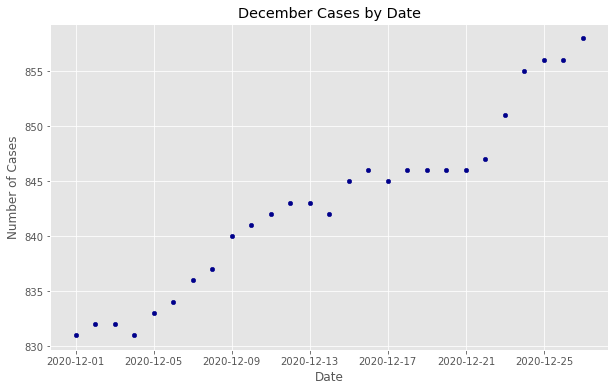

In [368]:
df2 = df_ZipCOVIDDecember.groupby('ReportDate').count()
df2.reset_index(inplace=True)
df2.head()

df2.plot(kind='scatter', x='ReportDate', y='NumCases', figsize=(10, 6), color='darkblue')

plt.title('December Cases by Date')
plt.xlabel('Date')
plt.ylabel('Number of Cases')

plt.show()


**QUESTION:** what are population distributions in the 'above' and 'below' segments?


In [374]:
df_ZipCOVIDUnion.head()

,zip,Latitude,Longitude,city,county,pop,areaName,DecNumCases,DecCOVIDPerCap,aboveorbelow
0,23887,36.563755,-77.82652,Valentines,Brunswick,387.0,"Valentines, Brunswick (23887)",0.0,0.000000,below
1,24656,37.198005,-82.12193,Vansant,Buchanan,2812.0,"Vansant, Buchanan (24656)",46.0,0.016358,above
2,24149,37.011934,-80.41897,Riner,Montgomery,3530.0,"Riner, Montgomery (24149)",52.0,0.014731,above
3,23125,37.342721,-76.27989,New Point,Mathews,255.0,"New Point, Mathews (23125)",1.0,0.003922,below
4,22652,38.823987,-78.45310,Fort Valley,Shenandoah,1339.0,"Fort Valley, Shenandoah (22652)",7.0,0.005228,below


<AxesSubplot:title={'center':'pop'}, xlabel='aboveorbelow'>

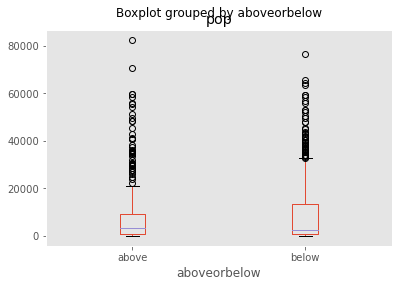

In [376]:
df_ZipCOVIDUnion.boxplot(by ='aboveorbelow', column =['pop'], grid = False)

Cases appear to have increased at a relatively rapid rate between December 5th and 12th, slowed between the 13th and 22nd, then again at a relatively rapid rate between December 22nd and 27th.

**Where are the above's and below's in Virginia?**

Red dots are zip codes with above average per capita infections in December.

Blue dots are zip codes with below average per capita infections in December.


In [287]:
map_abovebelow = folium.Map(location=[37.926868, -79.124902], zoom_start=7)

# add markers to map
for lat, lng, label, colorcat in zip(df_ZipsToUse['Latitude'], df_ZipsToUse['Longitude'], df_ZipsToUse['areaName'],df_ZipsToUse['aboveorbelow']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'red' if colorcat == 'above' else 'blue',
        fill=True,
        fill_color = 'lightred' if colorcat == 'above' else 'lightblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_abovebelow)  

map_abovebelow

#### Exploring nearby_venues

What are the counts of the venues in each category?


In [229]:
nearby_venues.groupby('Venue Category').count()

,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
ATM,14,14,14,14,14,14
Accessories Store,15,15,15,15,15,15
Adult Boutique,5,5,5,5,5,5
Advertising Agency,3,3,3,3,3,3
Afghan Restaurant,6,6,6,6,6,6
...,...,...,...,...,...,...
Wings Joint,47,47,47,47,47,47
Women's Store,28,28,28,28,28,28
Yoga Studio,51,51,51,51,51,51


Here are the top 25 categories of venues in the state or Virginia:

In [231]:
nearby_venues.groupby('Venue Category').count().sort_values(by='areaName', ascending=False).head(25)

,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Pizza Place,597,597,597,597,597,597
Fast Food Restaurant,532,532,532,532,532,532
Convenience Store,508,508,508,508,508,508
American Restaurant,488,488,488,488,488,488
Sandwich Place,480,480,480,480,480,480
Coffee Shop,383,383,383,383,383,383
Discount Store,331,331,331,331,331,331
Mexican Restaurant,324,324,324,324,324,324
Park,286,286,286,286,286,286


Here are the top 150 venue categories when the areaName has an **above average** per capita infection rate:

In [288]:
df_topVenuesAbove = nearby_venues[nearby_venues['areaName'].isin(df_ZipsToUse[df_ZipsToUse['aboveorbelow'] == 'above']['areaName'])].groupby('Venue Category').count().sort_values(by='areaName', ascending=False).head(50)
df_topVenuesAbove.reset_index(inplace=True)
df_topVenuesAbove.head(50)

,Venue Category,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Fast Food Restaurant,234,234,234,234,234,234
1,Pizza Place,222,222,222,222,222,222
2,American Restaurant,193,193,193,193,193,193
3,Sandwich Place,184,184,184,184,184,184
4,Convenience Store,181,181,181,181,181,181
5,Discount Store,144,144,144,144,144,144
6,Hotel,115,115,115,115,115,115
7,Mexican Restaurant,113,113,113,113,113,113
8,Coffee Shop,108,108,108,108,108,108
9,Pharmacy,108,108,108,108,108,108


Here are the top 50 venue categories when the areaName has an **below average** per capita infection rate:

In [291]:
df_bottomVenuesBelow = nearby_venues[nearby_venues['areaName'].isin(df_ZipsToUse[df_ZipsToUse['aboveorbelow'] == 'below']['areaName'])].groupby('Venue Category').count().sort_values(by='areaName', ascending=False).head(50)
df_bottomVenuesBelow.reset_index(inplace=True)
df_bottomVenuesBelow.head(50)

,Venue Category,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Pizza Place,375,375,375,375,375,375
1,Convenience Store,327,327,327,327,327,327
2,Fast Food Restaurant,298,298,298,298,298,298
3,Sandwich Place,296,296,296,296,296,296
4,American Restaurant,295,295,295,295,295,295
5,Coffee Shop,275,275,275,275,275,275
6,Mexican Restaurant,211,211,211,211,211,211
7,Park,197,197,197,197,197,197
8,Discount Store,187,187,187,187,187,187
9,Chinese Restaurant,169,169,169,169,169,169


### Findings after EDA

There is not much difference in the categories that make up the top 50 lists. Although a couple things did stand out:

1. While there are fewer zip codes with above average infections, there are a similar number of **Fast Food** restaurants in both the above and below zip codes.
2. **Golf Courses** are not one of the 50 most frequent venue categories in the above average zip codes, but they are #44 in the below average zip codes. 


I only want to use the 150 most frequent categories represented in the top and bottom infection so, I need to filter by those categories.


In [292]:
print('There are {} unique venue categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 462 unique venue categories.


In [350]:
# Find venue categories unique to above segment
df_topVenuesAbove[~df_topVenuesAbove['Venue Category'].isin(df_bottomVenuesBelow['Venue Category'])]

,Venue Category,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
29,Construction & Landscaping,41,41,41,41,41,41
35,Thrift / Vintage Store,36,36,36,36,36,36
36,Korean Restaurant,36,36,36,36,36,36
40,Vietnamese Restaurant,33,33,33,33,33,33
42,Home Service,31,31,31,31,31,31
44,Mobile Phone Shop,30,30,30,30,30,30
45,Steakhouse,29,29,29,29,29,29
48,Rental Car Location,28,28,28,28,28,28
49,Japanese Restaurant,27,27,27,27,27,27


In [351]:
# Find venue categories unique to the below segment
df_bottomVenuesBelow[~df_bottomVenuesBelow['Venue Category'].isin(df_topVenuesAbove['Venue Category'])]

,Venue Category,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
24,Sushi Restaurant,96,96,96,96,96,96
34,Furniture / Home Store,77,77,77,77,77,77
40,Mediterranean Restaurant,71,71,71,71,71,71
42,Shopping Mall,67,67,67,67,67,67
43,Deli / Bodega,65,65,65,65,65,65
45,Golf Course,63,63,63,63,63,63
46,Indian Restaurant,60,60,60,60,60,60
47,Department Store,57,57,57,57,57,57
48,Middle Eastern Restaurant,56,56,56,56,56,56


In [293]:
frames = [df_topVenuesAbove, df_bottomVenuesBelow]

#concatenate dataframes
df_VenueCategoriesToUse = pd.concat(frames, sort=False)

print(df_VenueCategoriesToUse.shape)
df_VenueCategoriesToUse.head()

(100, 7)


,Venue Category,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Fast Food Restaurant,234,234,234,234,234,234
1,Pizza Place,222,222,222,222,222,222
2,American Restaurant,193,193,193,193,193,193
3,Sandwich Place,184,184,184,184,184,184
4,Convenience Store,181,181,181,181,181,181


In [294]:
print('There are {} unique venue categories.'.format(len(df_VenueCategoriesToUse['Venue Category'].unique())))

There are 59 unique venue categories.


We have **59** unique categories we will use for analysis.

I will filter the nearby_venues DataFrame to only include venues in those categories.

In [295]:
df_VenuesToUse = nearby_venues[nearby_venues['Venue Category'].isin(df_VenueCategoriesToUse['Venue Category'])]
print(df_VenuesToUse.shape)
df_VenuesToUse.head()

(10382, 7)


,areaName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Riner, Montgomery (24149)",37.0119,-80.419,bread basket,37.0183,-80.4289,Bakery
3,"New Point, Mathews (23125)",37.3427,-76.2799,Warung Kopi Fauzan Lampineung,37.3534,-76.2856,Café
4,"New Point, Mathews (23125)",37.3427,-76.2799,Tower Coffee,37.3534,-76.2856,Coffee Shop
9,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Stone Hot Pizza,38.8406,-77.1209,Pizza Place
13,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Clyde's at Mark Center,38.8334,-77.123,American Restaurant


In [296]:
print('There are {} unique areaNames (zip codes).'.format(len(df_VenuesToUse['areaName'].unique())))

There are 647 unique areaNames (zip codes).


Some Virginia zip codes are not represente in the filtered FourSquare DataFrame. There are a total of 891 zip codes in our COVID DataFrame, but some of those zip codes may be too rural to have FourSquare information available.

I will filter the df_ZipsToUse to only inlcude records in the df_VenuesToUse.

In [297]:
df_ZipsToUse = df_ZipsToUse[df_ZipsToUse['areaName'].isin(df_VenuesToUse['areaName'].unique())]
print(df_ZipsToUse.shape)
df_ZipsToUse.head()

(647, 8)


,level_0,index,zip,Latitude,Longitude,pop,areaName,aboveorbelow
0,0,548,24210,36.728639,-82.00845,16779.0,"Abingdon, Washington (24210)",above
1,1,659,24211,36.657812,-81.96207,9344.0,"Abingdon, Washington (24211)",above
2,2,204,23301,37.713561,-75.67108,1580.0,"Accomac, Accomack (23301)",above
5,5,246,20105,38.964054,-77.60878,21385.0,"Aldie, Loudoun (20105)",below
6,6,282,22301,38.819863,-77.05854,13569.0,"Alexandria, Alexandria City (22301)",below


In [298]:
df_ZipsToUse.groupby('aboveorbelow').count()

,level_0,index,zip,Latitude,Longitude,pop,areaName
aboveorbelow,,,,,,,
above,261,261,261,261,261,261,261
below,386,386,386,386,386,386,386


Remap the df_ZipsToUse to determine if we still have adequate counts and distribution for a meaningful analysis of Virginia.

In [299]:
map_abovebelow2 = folium.Map(location=[37.926868, -79.124902], zoom_start=7)

# add markers to map
for lat, lng, label, colorcat in zip(df_ZipsToUse['Latitude'], df_ZipsToUse['Longitude'], df_ZipsToUse['areaName'],df_ZipsToUse['aboveorbelow']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'red' if colorcat == 'above' else 'blue',
        fill=True,
        fill_color = 'lightred' if colorcat == 'above' else 'lightblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_abovebelow2)  

map_abovebelow2

The map and counts appear to still be valid.

### Prepping the venue data for Machine Learning

**Add areaName** to the df_VenuesToUse DataFrame based on the areaName in df_ZipsToUse

In [321]:
df_ZipsVenuesToUse = df_VenuesToUse.merge(df_ZipsToUse, on='areaName', how='left')

In [322]:
df_ZipsVenuesToUse = df_ZipsVenuesToUse.drop(['Latitude_y','Longitude_y'], axis=1)
print(df_ZipsVenuesToUse.shape)
df_ZipsVenuesToUse.head(10)

(10382, 12)


,areaName,Latitude_x,Longitude_x,Venue,Venue Latitude,Venue Longitude,Venue Category,level_0,index,zip,pop,aboveorbelow
0,"Riner, Montgomery (24149)",37.0119,-80.419,bread basket,37.0183,-80.4289,Bakery,558,2,24149,3530.0,above
1,"New Point, Mathews (23125)",37.3427,-76.2799,Warung Kopi Fauzan Lampineung,37.3534,-76.2856,Café,433,3,23125,255.0,below
2,"New Point, Mathews (23125)",37.3427,-76.2799,Tower Coffee,37.3534,-76.2856,Coffee Shop,433,3,23125,255.0,below
3,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Stone Hot Pizza,38.8406,-77.1209,Pizza Place,10,5,22311,18952.0,above
4,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Clyde's at Mark Center,38.8334,-77.123,American Restaurant,10,5,22311,18952.0,above
5,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Fairouz Cafe,38.8416,-77.1194,Mediterranean Restaurant,10,5,22311,18952.0,above
6,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Dunkin',38.8421,-77.1093,Donut Shop,10,5,22311,18952.0,above
7,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Beard Papa's,38.8441,-77.1192,Bakery,10,5,22311,18952.0,above
8,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Dairy Queen,38.8477,-77.1173,Ice Cream Shop,10,5,22311,18952.0,above
9,"Alexandria, Alexandria City (22311)",38.8373,-77.1206,Homewood Suites by Hilton,38.8445,-77.1119,Hotel,10,5,22311,18952.0,above


Create **dummy variables** for the Venue Categories.

In [323]:
# one hot encoding
df_Venues_Onehot = pd.get_dummies(df_ZipsVenuesToUse[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_Venues_Onehot['areaName'] = df_ZipsVenuesToUse['areaName']
df_Venues_Onehot['aboveorbelow'] = df_ZipsVenuesToUse['aboveorbelow']

# move neighborhood column to the first column
#fixed_columns = ['areaName','zip','Latitude_x','Latitude_y',] + list(df_Toronto_Onehot.columns[:-1])
#df_Toronto_Onehot = df_Toronto_Onehot[fixed_columns]

df_Venues_Onehot.head(2)

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Breakfast Spot,Brewery,Burger Joint,Café,...,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Video Store,Vietnamese Restaurant,areaName,aboveorbelow
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Riner, Montgomery (24149)",above
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"New Point, Mathews (23125)",below


In [324]:
df_Venues_Grouped = df_Venues_Onehot.groupby('areaName').mean().reset_index()
df_Venues_Grouped.sort_values(by='areaName',inplace=True)
df_Venues_Grouped.reset_index(inplace=True)
print(df_Venues_Grouped.shape)
df_Venues_Grouped.head()

(647, 61)


,index,areaName,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Breakfast Spot,Brewery,...,Shopping Mall,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Video Store,Vietnamese Restaurant
0,0,"Abingdon, Washington (24210)",0.0000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
1,1,"Abingdon, Washington (24211)",0.0000,0.0,0.000000,0.000000,0.0,0.0,0.333333,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
2,2,"Accomac, Accomack (23301)",0.0000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
3,3,"Aldie, Loudoun (20105)",0.0000,0.0,0.333333,0.333333,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
4,4,"Alexandria, Alexandria City (22301)",0.0625,0.0,0.031250,0.046875,0.0,0.0,0.015625,0.0,...,0.0,0.046875,0.0,0.015625,0.015625,0.03125,0.015625,0.015625,0.0,0.0


In [327]:
print(df_ZipsToUse.shape)
df_ZipsToUse.sort_values(by='areaName',inplace=True)#
#df_ZipsToUse.reset_index(inplace=True)
df_ZipsToUse.head()

(647, 8)


,level_0,index,zip,Latitude,Longitude,pop,areaName,aboveorbelow
0,0,548,24210,36.728639,-82.00845,16779.0,"Abingdon, Washington (24210)",above
1,1,659,24211,36.657812,-81.96207,9344.0,"Abingdon, Washington (24211)",above
2,2,204,23301,37.713561,-75.67108,1580.0,"Accomac, Accomack (23301)",above
5,5,246,20105,38.964054,-77.60878,21385.0,"Aldie, Loudoun (20105)",below
6,6,282,22301,38.819863,-77.05854,13569.0,"Alexandria, Alexandria City (22301)",below


Add back in the aboveorbelow column to the df_Venues_Grouped

In [328]:
df_Venues_Grouped['aboveorbelow'] = df_ZipsToUse['aboveorbelow']
df_Venues_Grouped['pop'] = df_ZipsToUse['pop']

In [330]:
df_Venues_Grouped = df_Venues_Grouped.drop(['index'], axis=1)

In [331]:
print(df_Venues_Grouped.shape)
df_Venues_Grouped.head(3)

(647, 62)


,areaName,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Breakfast Spot,Brewery,Burger Joint,...,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Video Store,Vietnamese Restaurant,aboveorbelow,pop
0,"Abingdon, Washington (24210)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,above,16779.0
1,"Abingdon, Washington (24211)",0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,above,9344.0
2,"Accomac, Accomack (23301)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,above,1580.0


In the DataFrame there are:
* **647** areas/zipcodes
* **59** Venue Categories - columns 1-164

### Train and Test the Support Vector Machine to identify above or below zipcodes based on venue categories present in the zipcode

From IBM's Skills Development Network, "SVM's work by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong."

In [332]:
df_SVMFeatures = df_Venues_Grouped.drop(['areaName','aboveorbelow'], axis=1)
X = np.asarray(df_SVMFeatures)
X[0]

array([0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 3.33e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       1.67e-01, 0.00e+00, 1.67e-01, 0.00e+00, 0.00e+00, 1.67e-01,
       0.00e+00, 0.00e+00, 0.00e+00, 1.67e-01, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.68e+04])

In [335]:
df_SVMFeatures.fillna(0, inplace=True)
#df_SVMFeatures.isnull().values.any()
df_SVMFeatures.isnull().sum().sum()

0

We want the model to predict the value of above or below (that is, above average infections per capita (=1) or below average infections per capita (=0)). As this field can have one of only two possible values, we need to change its value level to reflect this.

In [336]:
y = np.asarray(np.where(df_Venues_Grouped['aboveorbelow']=='above', 1, 0))
y

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

#### Split into train and test data sets

Import needed libraries for the SVM model.

In [310]:
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [337]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (517, 60) (517,)
Test set: (130, 60) (130,)


I will use the default kernel function: RBF (Radial Basis Function).

In [338]:
from sklearn import svm
covid_svm_model = svm.SVC(kernel='rbf')
covid_svm_model.fit(X_train, y_train) 

SVC()

Use the trained model to predict values using the testing data:

In [339]:
yhat = covid_svm_model.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Review the performance of the model:

The model is **not** functional. It is unable to predict any zipcodes as having above average per capita COVID infections based on the types of venue catories in the 2km radius of the zip code center.

### Try a Logistic model
Since the SVM did not work, I will try a logistic model using the same data.

#### Standardize the data:

In [340]:
XLog = preprocessing.StandardScaler().fit(X).transform(X)
XLog[0]

array([-0.4 , -0.26, -0.17, -0.21, -0.16, -0.24, -0.15, -0.16, -0.17,
       -0.2 , -0.39, -0.12, -0.32, -0.25, -0.43, -0.2 , -0.16, -0.24,
       -0.19,  2.55, -0.26, -0.53, -0.36, -0.14,  1.38, -0.18,  1.53,
       -0.22, -0.35,  0.78, -0.24, -0.28, -0.26,  1.66, -0.26, -0.12,
       -0.29, -0.34, -0.24, -0.29, -0.29, -0.14, -0.29, -0.53, -0.44,
       -0.19, -0.19, -0.45, -0.21, -0.17, -0.27, -0.15, -0.39, -0.32,
       -0.29, -0.13, -0.2 , -0.26, -0.18,  0.47])

#### Split the data into testing and training data sets:

In [341]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split( XLog, y, test_size=0.2, random_state=4)
print ('Train set:', X_train_log.shape,  y_train_log.shape)
print ('Test set:', X_test_log.shape,  y_test_log.shape)

Train set: (517, 60) (517,)
Test set: (130, 60) (130,)


#### Build the logistic model with the training data

In [342]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_log,y_train_log)
LR

LogisticRegression(C=0.01, solver='liblinear')

#### Predict with the test data

In [343]:
yhat_log = LR.predict(X_test_log)
yhat_log

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

***This model is at least predicting some above and some below***

#### Evaluate the Logistic Model

In [344]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test_log, yhat_log)

0.078125

This performance is **not** ideal with a Jaccard Score of ~0.26. 

#### Evaluate the performance with a confusion matrix ...
 to see if false positives or false negatives are more of a problem for the mode.

In [345]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test_log, yhat_log, labels=[1,0]))

[[ 5 44]
 [15 66]]


Confusion matrix, without normalization
[[ 5 44]
 [15 66]]


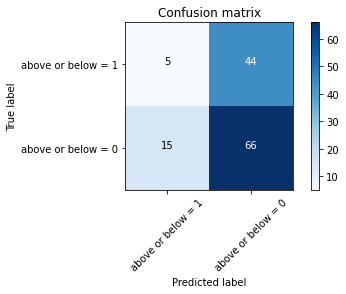

In [346]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_log, yhat_log, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['above or below = 1','above or below = 0'],normalize= False,  title='Confusion matrix')

The logistic regression model does not perform well at predicting true above average per capita COVID infections. It performs better at predicting below average per capita COVID infections. In other words, it has a **high false negative rate** which is unacceptable.

## Results

COVID-19 infections are being spread via comunity spread throughout Virginia. It would be helpful for communities to understand their local risk based on easily available data. However, using FourSquare venue information I was unable to create a well-performing model using either a Support Vector Machine (SVM) or Logistic Regression. The SVM model was unable to predict any above average per-capita infection zip codes using the ratios of the top venue categories and zip code populations. The Logistic Regression model had a high false negative rate. 

## Discussion

I had expected to be able to use **trending** FourSquare venues instead of **explore** FourSquare venues. Trending venues would have unabled my model to use venues where people were physically attending during late December 2020. However, after 4 attempted at different times of day I was unable to retrieve any trending FourSquare locations. Either machine learning algoirthm may have performed satisfactorily with trending data.

Regardless of whether trending or explore data is used any investigation would have been limited to venues and venue cateories representing in FourSquare data which may not be complete. Additionally, people travel outside their zip code, so venue categories should not be thought of as predicting where people actually have acquired COVID-19 by community spread.

I used the 150 most frequent venue categories represented in the "above" average and "below" average per capita infection segments. Using a fewer or more categories may have produced better results.

## Conclusion

FourSquare venue categories within 2 kilometers of the center of Virginia zip codes are not a good predictive measure for whether a zip code have above or below COVID-19 per capita infection rates using either a SVM or logistic regression model.

## References
 Virgina Departments of Health: https://www.vdh.virginia.gov/coronavirus/frequently-asked-questions/general-questions/